In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [19]:
BACTH_SIZE = 64
LR = 0.01
EPOCH = 50
WEIGHT_DECAY = 0.001
torch.manual_seed(1)

100%|██████████| 170498071/170498071 [00:04<00:00, 42590787.26it/s]


Extracting /work/cifar/cifar-10-python.tar.gz to /work/cifar
Files already downloaded and verified


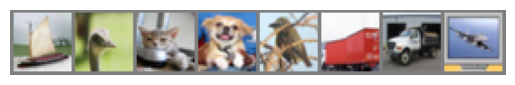

 ship  bird   cat   dog  bird truck truck plane


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='/work/cifar', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='/work/cifar', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BACTH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BACTH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[0:8]))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [4]:
print(f"Images shape:", images.shape)
print(f"Images min, mean, max:", torch.min(images), torch.mean(images), torch.max(images))
print(labels)


Images shape: torch.Size([64, 3, 32, 32])
Images min, mean, max: tensor(-1.) tensor(-0.0250) tensor(1.)
tensor([8, 2, 3, 5, 2, 9, 9, 0, 0, 8, 9, 6, 2, 2, 5, 6, 8, 4, 7, 9, 7, 7, 5, 3,
        3, 9, 8, 0, 1, 9, 6, 6, 2, 4, 6, 0, 4, 9, 1, 1, 7, 3, 4, 8, 9, 0, 6, 8,
        0, 3, 2, 2, 6, 6, 0, 9, 3, 2, 8, 2, 2, 4, 2, 6])


In [5]:
def create_plot(data, indices, title):
    plt.plot(indices, data, marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.show()

In [24]:
class BottleneckResidual(nn.Module):
    def __init__(self, in_channels, inner_count, out_channels, stride=1, downsample=None):
        super(BottleneckResidual, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, inner_count, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inner_count)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inner_count, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.input_filter = nn.Conv2d(in_channels, inner_count, kernel_size=1, stride=1, padding=0, bias=False)
        self.inner_filter = nn.Conv2d(inner_count, inner_count, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_inner = nn.BatchNorm2d(inner_count)
        self.output_filter = nn.Conv2d(inner_count, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn_outer = nn.BatchNorm2d(out_channels)


        self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels)
            )


    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)

        filtred = self.input_filter(x)
        filtred = self.inner_filter(filtred)
        filtred = self.bn_inner(filtred)
        filtred = self.output_filter(filtred)
        filtred = self.bn_outer(filtred)

        out += filtred
        out += residual
        out = self.relu(out)

        return out

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [25]:
class ResNetDyn(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetDyn, self).__init__()
        self.in_channels = 16
        self.conv = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = BottleneckResidual(self.in_channels, self.in_channels, 2 * self.in_channels)
        self.layer2 = BottleneckResidual(2 * self.in_channels, 3 * self.in_channels, 2 * self.in_channels, stride=1)
        self.layer3 = BottleneckResidual(2 * self.in_channels, 4 * self.in_channels, 3 * self.in_channels, stride=1)
        self.layer4 = BottleneckResidual(3 * self.in_channels, 3 * self.in_channels, 512, stride=1)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [26]:
device = torch.device("cuda")
model = ResNetDyn().to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)


In [27]:

count = 0
best_accuracy = 0
test_accuracy_list = []
test_error_list = []
train_accuracy_list = []
train_loss_list = []

for epoch in range(EPOCH):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        count += 1
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{EPOCH}], Loss: {running_loss / len(train_loader):.4f}, ' +
          f'Accuracy: {100 * correct / total:.2f}%')
    train_accuracy_list.append(correct / total)
    train_loss_list.append(running_loss / len(train_loader))
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_accuracy_list.append(test_accuracy)
    test_error_list.append(1 - test_accuracy)
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
    print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
    scheduler.step()

# Training complete visualization
print('Finished Training')

print(f'Best test Accuracy: {100 * best_accuracy:.2f}%')

Epoch [1/50], Loss: 1.6939, Accuracy: 37.15%
Test Accuracy: 46.60%
Epoch [2/50], Loss: 1.2540, Accuracy: 54.68%
Test Accuracy: 60.02%
Epoch [3/50], Loss: 1.0268, Accuracy: 63.30%
Test Accuracy: 66.34%
Epoch [4/50], Loss: 0.8974, Accuracy: 68.13%
Test Accuracy: 68.49%
Epoch [5/50], Loss: 0.8028, Accuracy: 71.79%
Test Accuracy: 71.17%
Epoch [6/50], Loss: 0.6163, Accuracy: 78.51%
Test Accuracy: 76.34%
Epoch [7/50], Loss: 0.5717, Accuracy: 80.00%
Test Accuracy: 77.00%
Epoch [8/50], Loss: 0.5448, Accuracy: 80.92%
Test Accuracy: 77.76%
Epoch [9/50], Loss: 0.5212, Accuracy: 81.88%
Test Accuracy: 78.42%
Epoch [10/50], Loss: 0.4981, Accuracy: 82.84%
Test Accuracy: 78.20%
Epoch [11/50], Loss: 0.4633, Accuracy: 84.13%
Test Accuracy: 78.96%
Epoch [12/50], Loss: 0.4563, Accuracy: 84.24%
Test Accuracy: 78.97%
Epoch [13/50], Loss: 0.4505, Accuracy: 84.39%
Test Accuracy: 78.96%
Epoch [14/50], Loss: 0.4502, Accuracy: 84.49%
Test Accuracy: 79.22%
Epoch [15/50], Loss: 0.4484, Accuracy: 84.52%
Test Accura

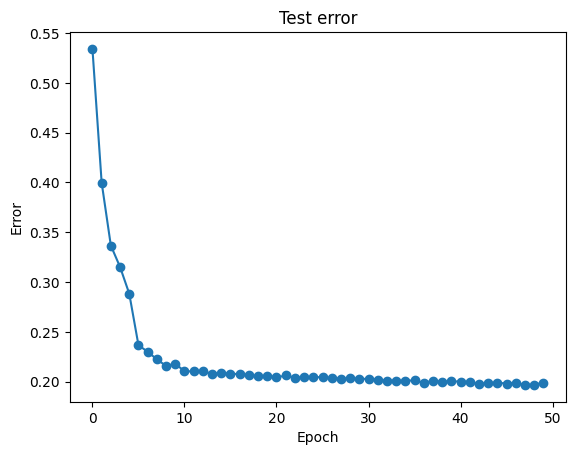

In [28]:
create_plot(test_error_list, [index for index in range(len(test_error_list))], "Test error")

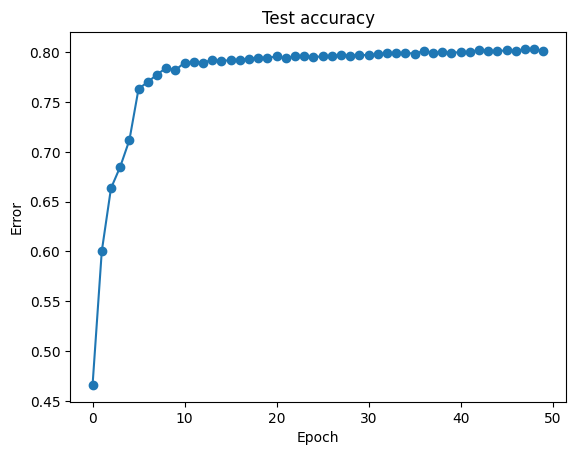

In [29]:
create_plot(test_accuracy_list, [index for index in range(len(test_accuracy_list))], "Test accuracy")

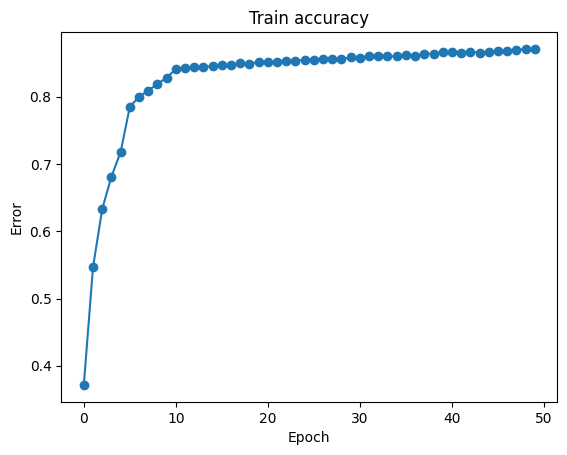

In [30]:
create_plot(train_accuracy_list, [index for index in range(len(train_accuracy_list))], "Train accuracy")



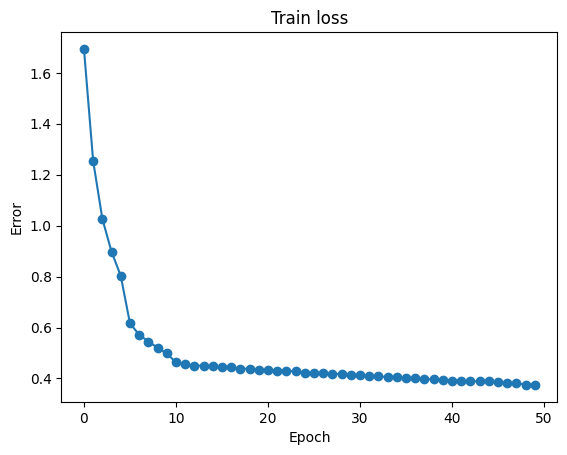

In [32]:
create_plot(train_loss_list, [index for index in range(len(train_loss_list))], "Train loss")